##### This notebook is focussed on finding the points of anomaly of a univariate timeseries data

# Imports

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data Handling

In [51]:
# Currently importing all the data into the csv
# Since currently the focus is on univariate time-series data, so the data
# we would have would only have two columns: {date, value}
df = pd.read_csv('catfish.csv')
df.head()

Date  Total
0  1986-1-01   9034
1  1986-2-01   9596
2  1986-3-01  10558
3  1986-4-01   9002
4  1986-5-01   9239

In [52]:
# following the convention of column names
df = df.rename(columns={'Date':'date', 'Total' : 'value' })
print(df.head())
print("Min-date: ", df['date'].min())
print("Max-date: ", df['date'].max())

        date  value
0  1986-1-01   9034
1  1986-2-01   9596
2  1986-3-01  10558
3  1986-4-01   9002
4  1986-5-01   9239
Min-date:  1986-1-01
Max-date:  2012-9-01


In [53]:
# Refer to this documentation for updating the format parameter below for any other date string format
# Datetime format: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  # Convert date column from string to datetime objects
df.set_index('date', inplace = True)
df.head()

value
date             
1986-01-01   9034
1986-02-01   9596
1986-03-01  10558
1986-04-01   9002
1986-05-01   9239

In [54]:
# Specify date range for analyzing
# start_date = pd.to_datetime("2010-01-01")
# end_date = pd.to_datetime("2019-01-01")
# df = df[start_date:end_date]
# print (df.head())


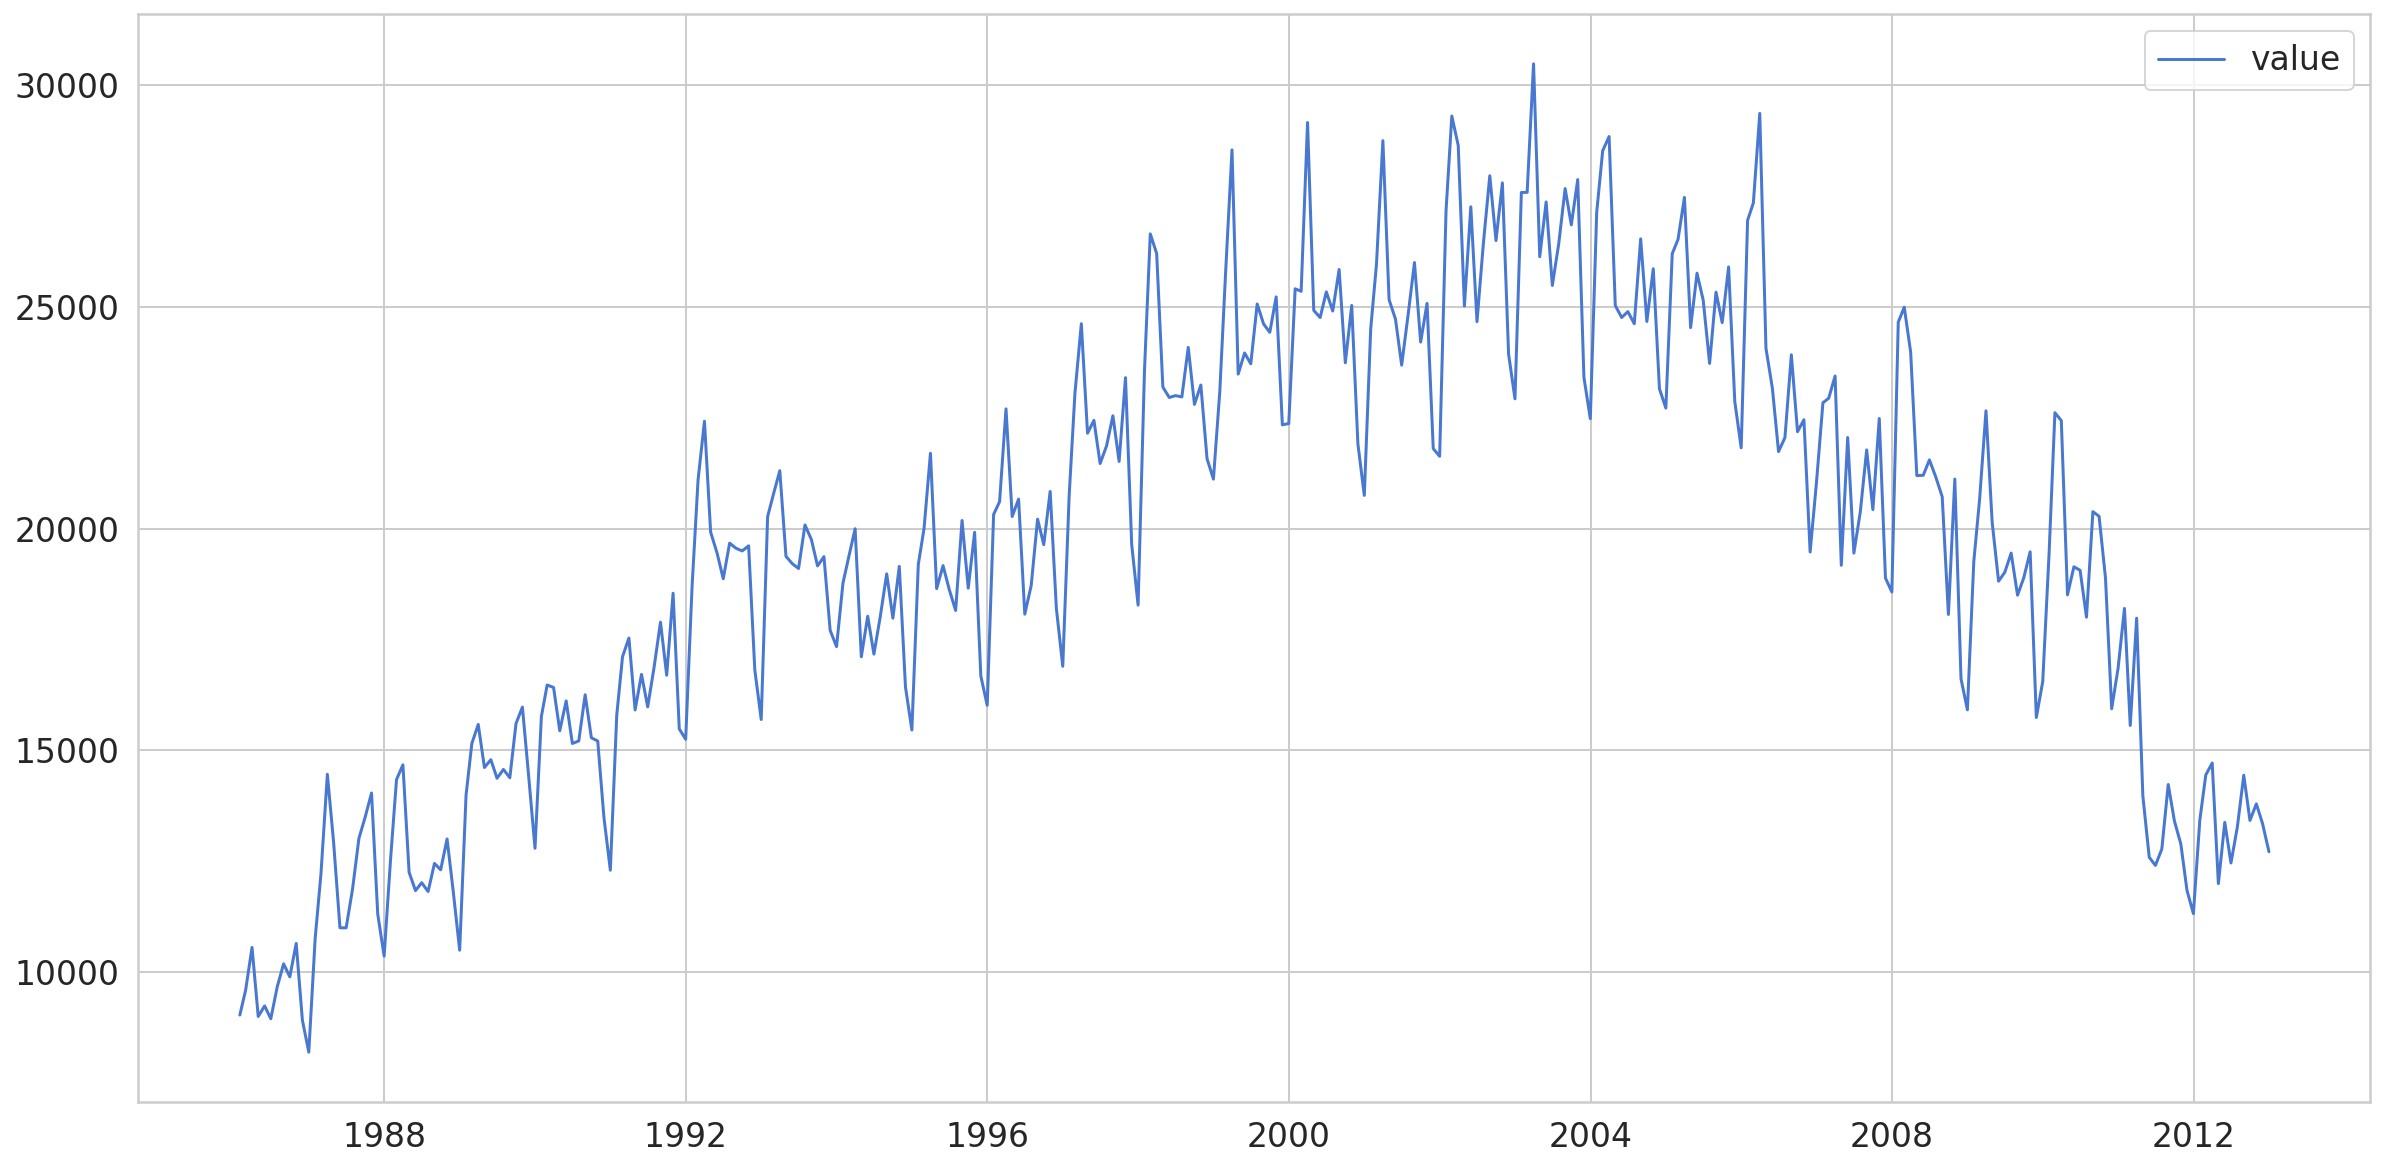

In [55]:
# Since we are going to use STL and it does not like non-uniform data. So we are going to make the data uniform
# by specifying a frequency and interpolating missing timestamps
df = df.resample('1M').pad() # move missing values to the front
# df = df.resample('1D').interpolate() # interpolate the missing values

# Plotting here is optional
plt.plot(df, label='value')
plt.legend()

# Separate seasonality and trend from data

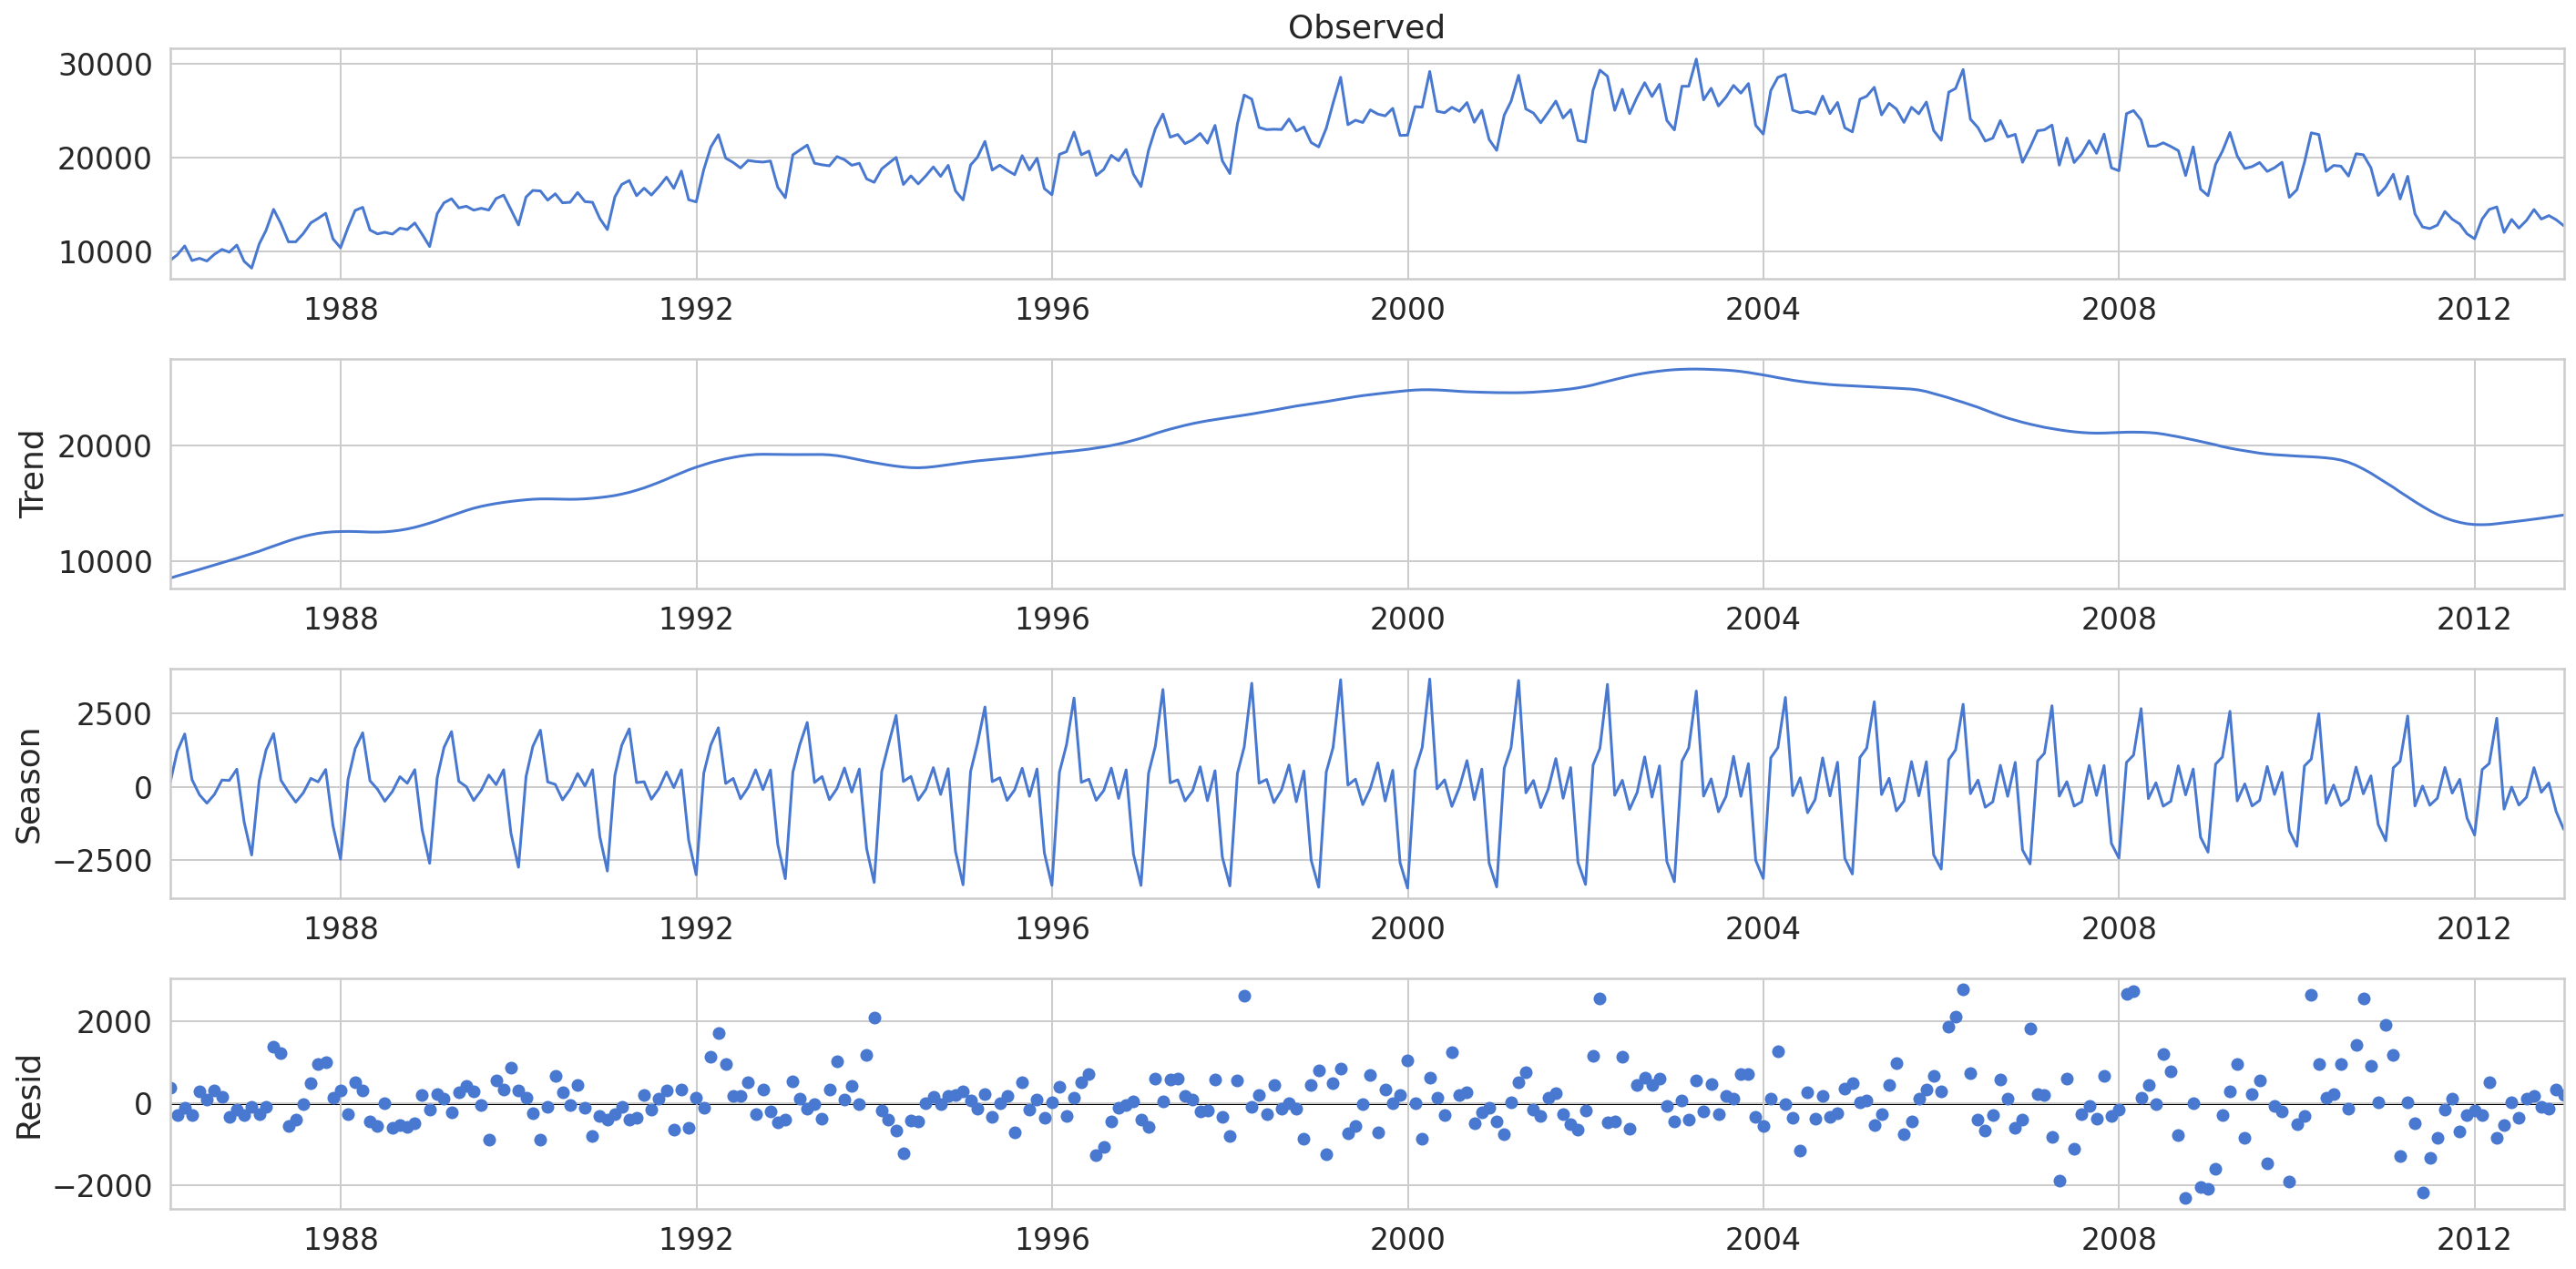

In [56]:
# First we would try to separate the seasonal, trend and residue from the data using STL
stl = STL(df, seasonal = 13, robust = True) # If the data does not contain many outliers then set robust to False
result = stl.fit()
fig = result.plot()

# Find anomalies from residue plot directly

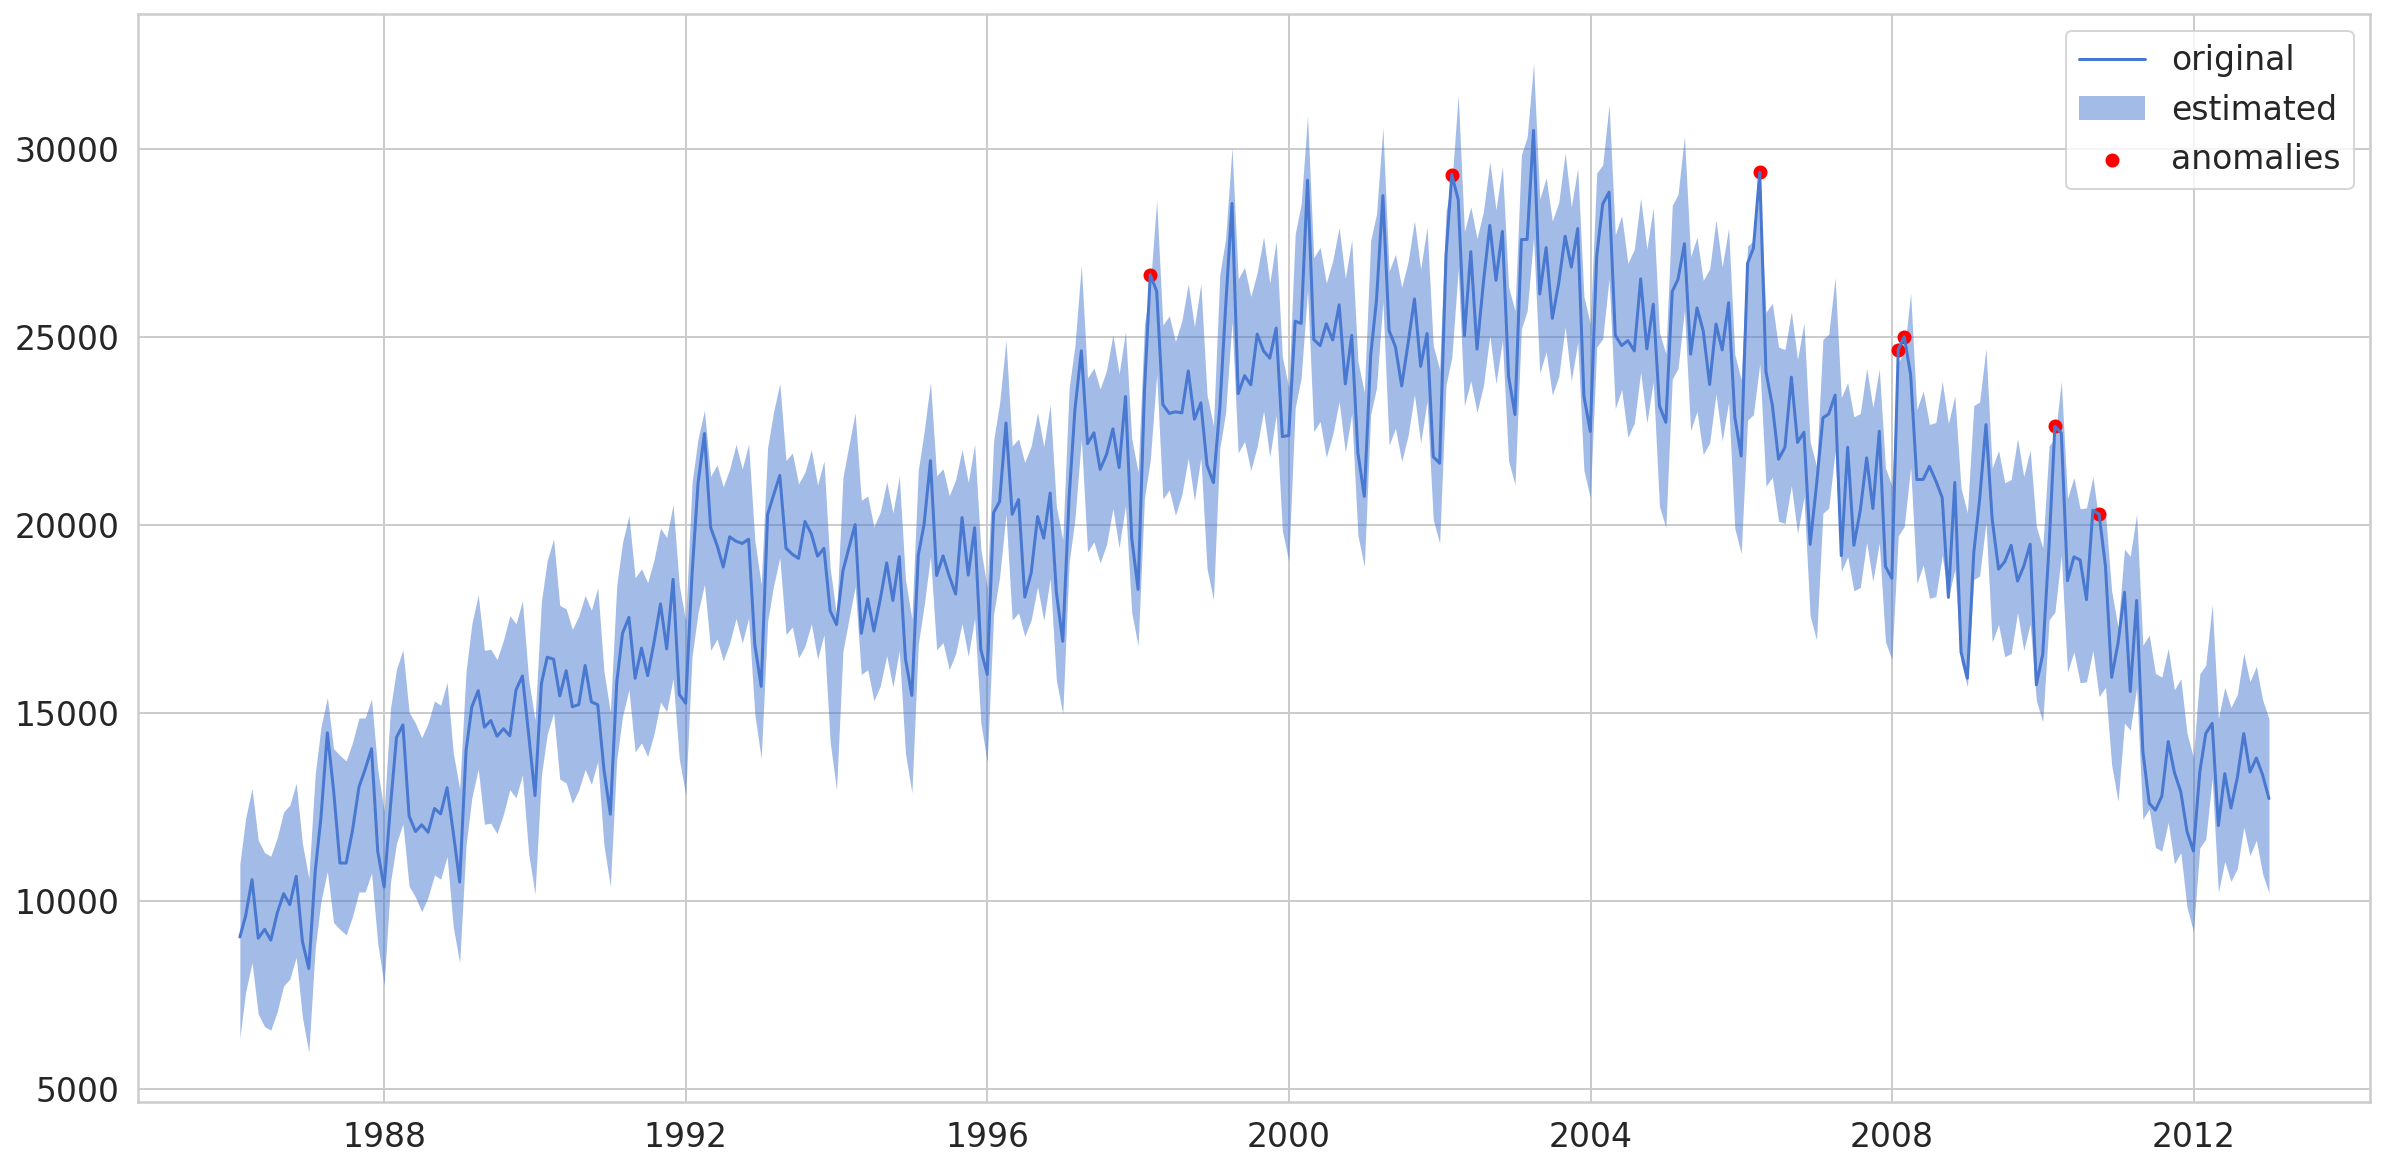

In [57]:
# Now we would compare the values with residual removed
non_residual = result.trend + result.seasonal
mean_residual = result.resid.mean()
std_residual = result.resid.std()
# threshold = 2000
threshold = mean_residual + 3*std_residual # This is one of the popular methods to choose range
anomalies = []
for d in df.index:
    if df.loc[d].value < non_residual.loc[d] - threshold or df.loc[d].value > non_residual.loc[d] + threshold:
        anomalies.append(df.loc[d])
# plt.plot(non_residual, label="residual_removed")
plt.fill_between(non_residual.index, non_residual-threshold, non_residual+threshold, alpha = 0.5, linewidth= 0, label = "estimated")
plt.plot(df, label="original")
if(len(anomalies) > 0):
    anomalies = pd.DataFrame(anomalies)
    plt.scatter(anomalies.index, anomalies.value,color='red', label="anomalies")
plt.legend()

# Find anomalies from residue plot using Clustering

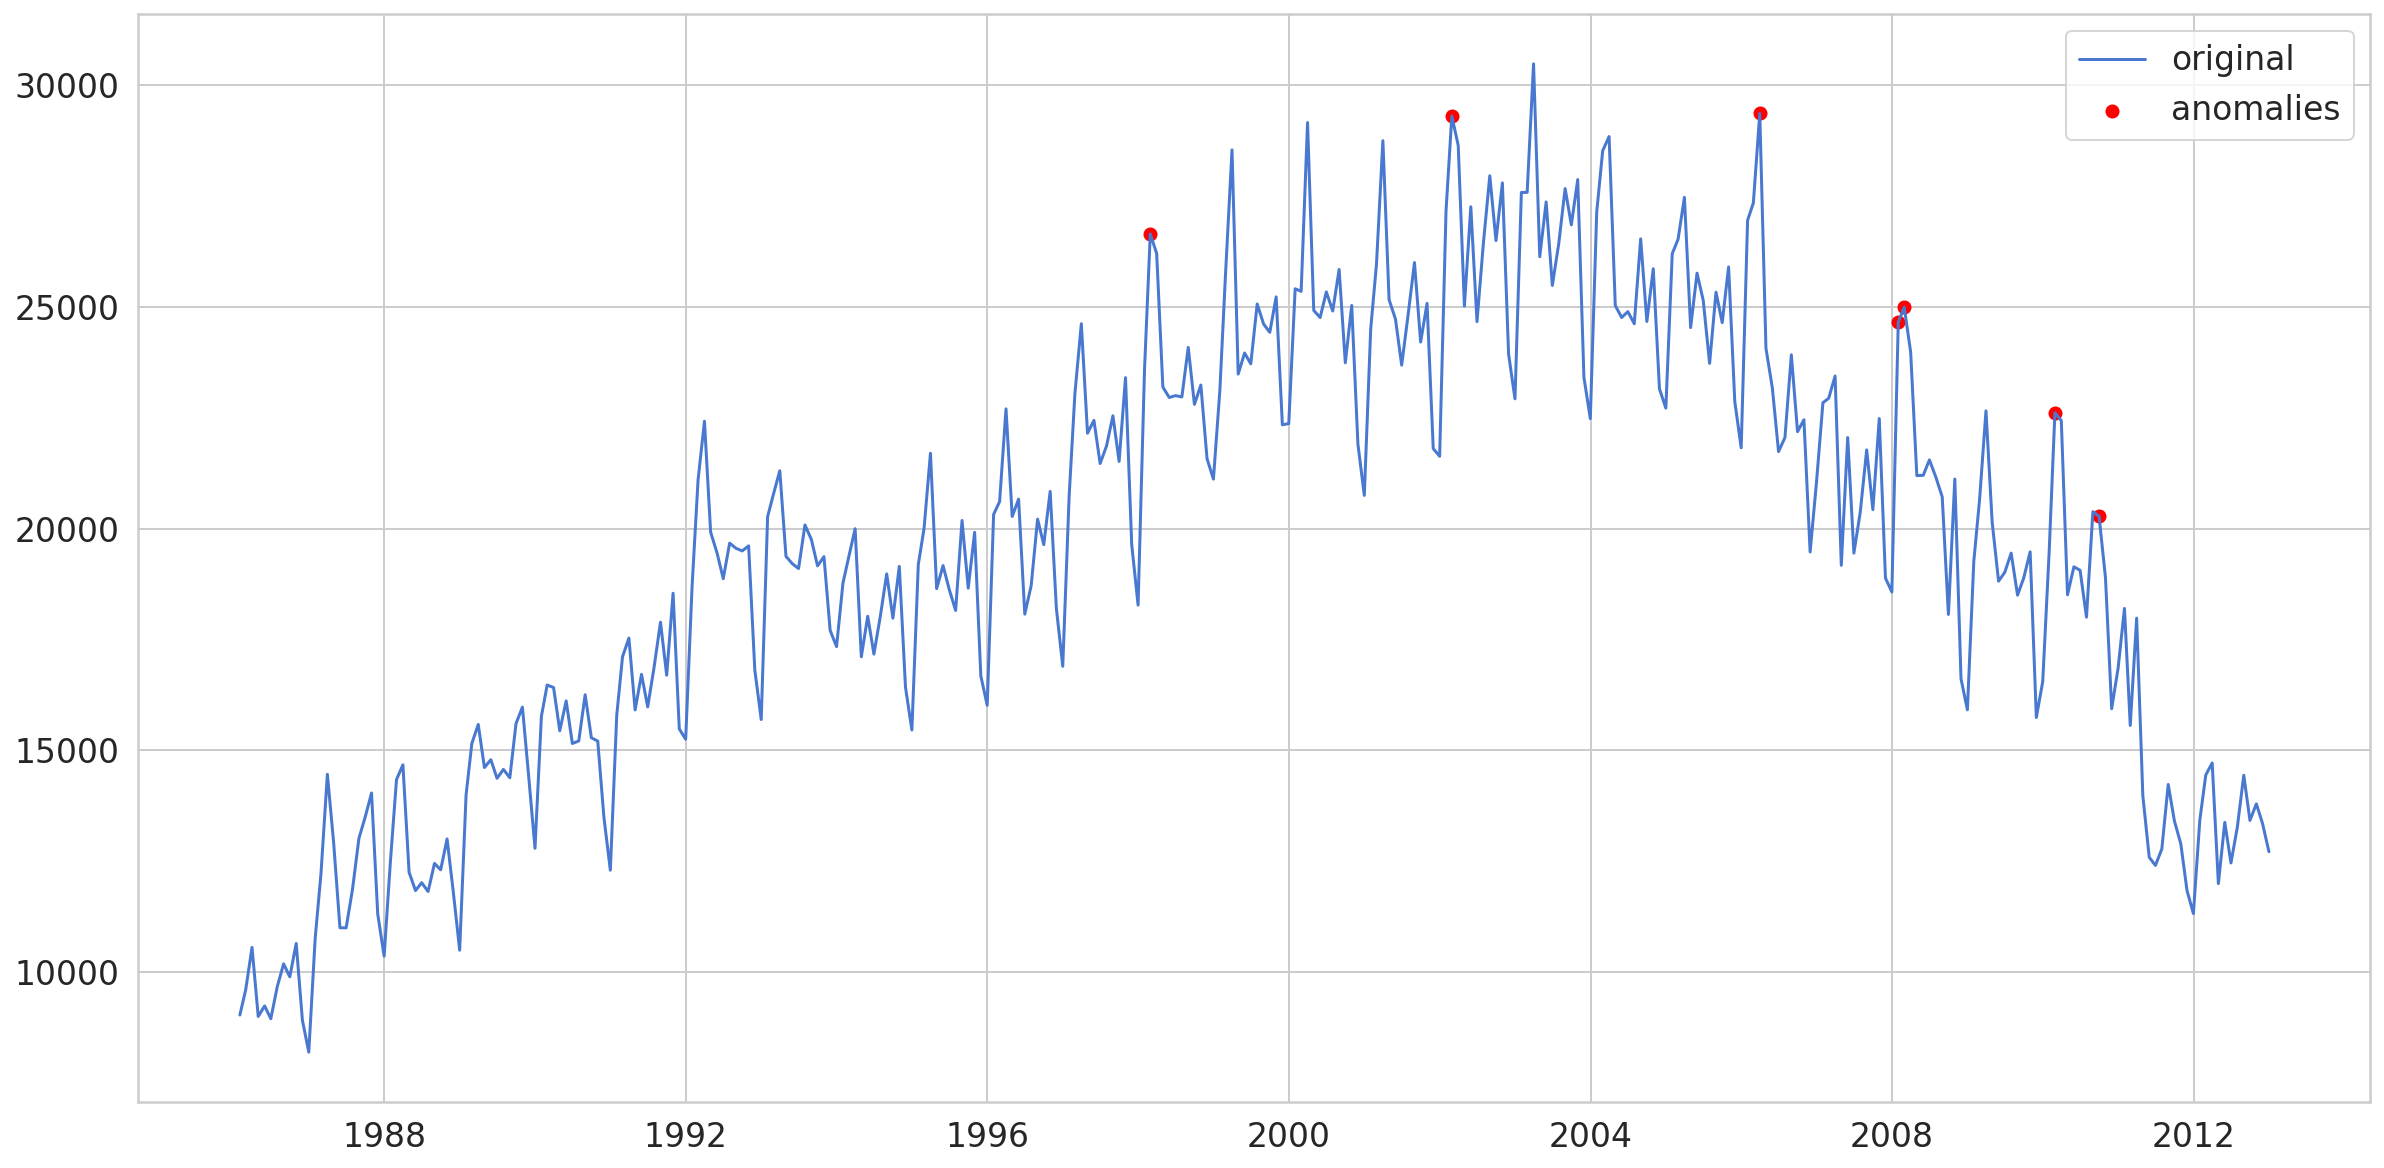

In [58]:
from sklearn.ensemble import IsolationForest
outliers_fraction = float(.01)
# scaler = StandardScaler()
# np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = result.resid.values
data = pd.DataFrame(data)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
anomalies_IF = model.predict(data)
# visualization
plt.plot(df, label="original")
plt.scatter(anomalies.index,anomalies, color='red', label = 'anomalies')
plt.legend()
plt.show();